In [ ]:
# !pip install matplotlib opencv-python
# !pip install --upgrade openai

In [13]:
#### Main Subject Repair (Auto)
#### Replace / Remove Image with User Masking
#### Text Refinement (Auto)

In [ ]:
# WORKFLOW
# 1. Obtain Image from Imagen / GPT
# 2. Reference Object Replacement
# 3. Perform Image Analysis
# 4. Check for Text & Branding - Cosine Similarity on Main Text & Rephrasing with Brand Name
# 5. Fine Tuning of Specific Regions

In [1]:
import os
import cv2
import json
import base64
import numpy as np
from PIL import Image
from openai import OpenAI
from matplotlib import pyplot as plt

import ipywidgets as widgets
from IPython.display import display

# from dotenv import load_dotenv
# load_dotenv("D:\Self-Project\LLM\agent_ads\.env")
# print(os.environ['OPENAI_API_KEY'])


In [109]:
base_path_upstream = r'D:\Self-Project\LLM\agent_ads\pipeline_upstream_outputs'
base_path_downstream = r'D:\Self-Project\LLM\agent_ads\pipeline_donwstream_outputs'

folder = 'tc027_low_creativity'
ctx_path = os.path.join(base_path_upstream, 'tc027_run_metadata.json')
image_path = os.path.join(base_path_downstream, f'{folder}/Whisk_dawngywodg.jpg')
image_path = image_path.replace('\\', '/')
print(image_path)

refernce_obj_path = os.path.join(base_path_downstream, f'{folder}/ref.jpeg')
refernce_obj_path = refernce_obj_path.replace('\\', '/')
print(refernce_obj_path)


D:/Self-Project/LLM/agent_ads/pipeline_donwstream_outputs/tc027_low_creativity/Whisk_dawngywodg.jpg
D:/Self-Project/LLM/agent_ads/pipeline_donwstream_outputs/tc027_low_creativity/ref.jpeg


##### Read Upstream Generations

In [110]:
# Get Ads Details from Context

idx = 0

with open(ctx_path, 'r') as file:
    ctx_json = json.load(file)
    

# Get Task Type & Platform
request_details = ctx_json.get('request_details')
task_type = request_details.get('task_type')
target_platform = request_details.get('target_platform')
platform_name = target_platform.get('name')
image_resolution_w = target_platform.get('resolution_details')['width']
image_resolution_h = target_platform.get('resolution_details')['height']
print("="*100)
print(f"Task Type : {task_type}\n")
print(f"Target Platform : {platform_name} \n")
print(f"Image Resolution : {image_resolution_w} x {image_resolution_h}")
print("="*100)

# Get User Input
user_input = ctx_json.get('user_inputs')
braning_elements = user_input.get('branding_elements')
task_description = user_input.get('task_description')
render_text = user_input.get('render_text')
apply_branding = user_input.get('apply_branding')
print(f"User Input : \n")
print(f"Render Text : {render_text}")
print(f"Task Describtion : {task_description}\n")
print(f"Apply Branding : {apply_branding}")
print(f"Branding Elements : {braning_elements}\n")
print("="*100)



# Get Markerting Options and Image Prompt
processing_ctx = ctx_json.get('processing_context')
marketing_options = processing_ctx.get('suggested_marketing_strategies')
image_prompts = processing_ctx.get('generated_image_prompts')

assert len(marketing_options) == len(image_prompts)
print(f"Loaded {len(image_prompts)} marketing options & image prompts.")

image_ctx_json = image_prompts[idx]
marketing_strat = marketing_options[idx]
print(f"Marketing Options Sample : \n {marketing_strat} \n")
print(f"Image Prompt Sample : \n {image_ctx_json}")
print("="*100)

# If reference image analysis is present
image_analysis_result = processing_ctx.get('image_analysis_result')
if image_analysis_result:
    analysis_main_obj = image_analysis_result.get('main_subject')
    print(f"Reference Image Analysis Exists: \n")
    print(f"Reference Main Object = {analysis_main_obj}")
    print("="*100)
    

Task Type : 5. Cultural & Community Content

Target Platform : Instagram Post (1:1 Square) 

Image Resolution : 1080 x 1080
User Input : 

Render Text : True
Task Describtion : Merdeka Day Celebration

Apply Branding : True
Branding Elements : EESOY

Loaded 5 marketing options & image prompts.
Marketing Options Sample : 
 {'target_audience': 'Young adults and families interested in traditional Malaysian culture and beverages', 'target_niche': 'Traditional Beverages', 'target_objective': 'Increase engagement by highlighting the heritage and artisanal process behind handcrafted soy milk for Merdeka Day', 'target_voice': 'Warm, nostalgic, and celebratory, evoking pride in cultural roots'} 

Image Prompt Sample : 
 {'visual_concept': {'main_subject': None, 'composition_and_framing': 'Symmetrical square layout with the handcrafted soy milk bottle placed exactly at the center on a circular polished wood slab. A slight top-down camera angle (~15°) reveals both the bottle’s label and surface t

Original Image Shape = (1024, 1024, 3)
Reference Image Shape = (1080, 810, 3)


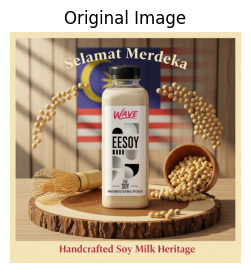

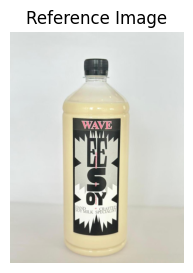

In [111]:

# Read image and convert back to RGB
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_h, img_w = image.shape[:2]
print(f"Original Image Shape = {image.shape}")

# Read Reference Image
ref_image = cv2.imread(refernce_obj_path)
ref_image_rgb = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)
print(f"Reference Image Shape = {ref_image_rgb.shape}")

plt.figure(figsize=(5, 3))
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')
plt.show()

plt.figure(figsize=(5, 3))
plt.imshow(ref_image_rgb)
plt.title("Reference Image")
plt.axis('off')
plt.show()

In [112]:
# if visual concept main_subject is NULL and analysis obj exists
# then set main_obj to be the analysis object 
# else remain None
main_obj = image_ctx_json['visual_concept']['main_subject']
if not main_obj:
    if analysis_main_obj:
        print(f"Setting Main Object of Visual Context to Analysis Main Object - {analysis_main_obj}")
        main_obj = analysis_main_obj

Setting Main Object of Visual Context to Analysis Main Object - Bottle of handcrafted soy milk


##### Generate Prompt

In [113]:

prompt = f"""
You are editing a base image using a reference object image. The goal is to create a realistic and visually consistent composition based on the provided visual concept.

**Instructions**:
1. Replace the main object in the base image with relevant content from the reference image.
    - The reference object must retain its **exact shape, proportions, visual aesthetics and text** when inserted.
    - **Do not reinterpret or creatively modify** the reference object — replicate it **as-is**.

2. The following visual concept was used during the generation of the original image. It may not fully align with the current image but can serve as **an optional creative reference** to guide stylistic consistency and atmosphere:

    Visual Concept:
    - Main Subject: {main_obj}
    - Composition & Framing: {image_ctx_json['visual_concept']['composition_and_framing']}
    - Background Environment: {image_ctx_json['visual_concept']['background_environment']}
    - Foreground Elements: {image_ctx_json['visual_concept']['foreground_elements']}
    - Lighting & Mood: {image_ctx_json['visual_concept']['lighting_and_mood']}
    - Color Palette: {image_ctx_json['visual_concept']['color_palette']}
    - Visual Style: {image_ctx_json['visual_concept']['visual_style']}
    - Texture & Details: {image_ctx_json['visual_concept']['texture_and_details']}
    - Creative Reasoning: {image_ctx_json['visual_concept']['creative_reasoning']}
    - Text Visuals : {image_ctx_json['visual_concept']['promotional_text_visuals']}
    - Branding Visuals : {image_ctx_json['visual_concept']['branding_visuals']}

3. Seamlessly match the lighting, texture, perspective, and depth of field of the base image so that the inserted object looks naturally integrated.
4. Align the inserted content with the image’s narrative and composition principles (e.g., rule of thirds, natural diagonals, balance of elements).
5. Ensure all elements in the edited image are visually coherent and logically consistent within the scene.
6. Correct any visual or contextual inconsistencies introduced during the edit to maintain a believable and polished composition.
7. Return only the edited base image, fully rendered and coherent. Do not include or concatenate the reference image.
"""

print(prompt)


You are editing a base image using a reference object image. The goal is to create a realistic and visually consistent composition based on the provided visual concept.

**Instructions**:
1. Replace the main object in the base image with relevant content from the reference image.
    - The reference object must retain its **exact shape, proportions, visual aesthetics and text** when inserted.
    - **Do not reinterpret or creatively modify** the reference object — replicate it **as-is**.

2. The following visual concept was used during the generation of the original image. It may not fully align with the current image but can serve as **an optional creative reference** to guide stylistic consistency and atmosphere:

    Visual Concept:
    - Main Subject: Bottle of handcrafted soy milk
    - Composition & Framing: Symmetrical square layout with the handcrafted soy milk bottle placed exactly at the center on a circular polished wood slab. A slight top-down camera angle (~15°) reveals b

##### Edit Image

In [ ]:
image_client = OpenAI(api_key='')

moderation = 'auto'
quality = 'high'

result = image_client.images.edit(
    model="gpt-image-1",
    image=[
        open(image_path, "rb"),
        open(refernce_obj_path, "rb"),
    ],
    prompt=prompt,
    quality=quality,
    size='1024x1024'
)

image_base64 = result.data[0].b64_json
image_bytes = base64.b64decode(image_base64)

In [115]:
# Save the image to a file
ref_replace_filename = f"{base_path_downstream}/{folder}/image-edit-{idx}-1.png"

if os.path.exists(ref_replace_filename):
    raise ValueError("Image Path already Exists !")

with open(ref_replace_filename, "wb") as f:
    f.write(image_bytes)

#### Erase

Original Image Shape = (1024, 1024, 3)


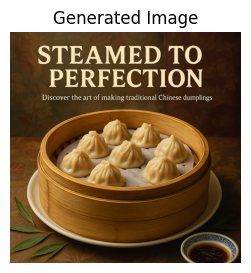

In [69]:
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_h, img_w = image.shape[:2]
print(f"Original Image Shape = {image.shape}")

plt.figure(figsize=(5, 3))
plt.imshow(image_rgb)
plt.title("Generated Image")
plt.axis('off')
plt.show()

In [9]:
mode_selection = widgets.RadioButtons(
    options=['Remove', 'Replace'],
    description='Select Erase Mode:',
    disabled=False
)


replacement_input = widgets.Text(
    placeholder='Enter replacement text here',
    description='Replace With:',
    disabled=False
)

display(mode_selection, replacement_input)


RadioButtons(description='Select Erase Mode:', options=('Remove', 'Replace'), value='Remove')

Text(value='', description='Replace With:', placeholder='Enter replacement text here')

In [31]:
selected_erase_mode = mode_selection.value
replacement_text = replacement_input.value
print(f"Mode : {selected_erase_mode}, Replacement Object : {replacement_text}")

# Prompt user to highlight the selected region 
roi = cv2.selectROI("Select ROI", image, fromCenter=False, showCrosshair=True)
cv2.destroyAllWindows()

# Extract coordinates
x, y, w, h = roi
print(f"Selected ROI: x={x}, y={y}, w={w}, h={h}")
   
# Create mask: start with a fully opaque white image with alpha channel
mask = image_rgb.copy()
# mask = np.ones((img_h, img_w, 4), dtype=np.uint8) * 255  # White RGBA

# Set ROI area to fully transparent
mask[y:y+h, x:x+w] = 0  # Set alpha to 0 (transparent)
# mask[y:y+h, x:x+w, 3] = 0  # Set alpha to 0 (transparent)

# Optional: Save the mask as PNG with alpha channel
mask_image = Image.fromarray(mask)
mask_image.save("edit_mask_alpha.png", format="PNG")
print(f"Masked image saved.")
 

Mode : Remove, Replacement Object : 
Selected ROI: x=0, y=842, w=157, h=133
Masked image saved.


In [ ]:
# Construct prompt based on selected mode
# Set main objective
if selected_erase_mode == 'Replace':
    erase_objective = "1. Fill in the masked region with content that logically and visually completes the scene with soy beans."
    image_visual_ctx = """
    5. Use cues from the **surrounding context** — textures, lighting, shadows, perspective, and composition — to generate a seamless and coherent fill.
    6. If available, you may refer to the following visual concept used to guide the image’s original generation. This concept is optional and may help inspire the style, mood, or subject matter of the completed region:

        Visual Concept:
        - Main Subject: {main_obj}
        - Composition & Framing: {image_ctx_json['visual_concept']['composition_and_framing']}
        - Background Environment: {image_ctx_json['visual_concept']['background_environment']}
        - Foreground Elements: {image_ctx_json['visual_concept']['foreground_elements']}
        - Lighting & Mood: {image_ctx_json['visual_concept']['lighting_and_mood']}
        - Color Palette: {image_ctx_json['visual_concept']['color_palette']}
        - Visual Style: {image_ctx_json['visual_concept']['visual_style']}
        - Texture & Details: {image_ctx_json['visual_concept']['texture_and_details']}
        - Creative Reasoning: {image_ctx_json['visual_concept']['creative_reasoning']}
    """
else: 
    # erase_objective = "1. Reconstruct the masked region based on the surrounding scene. Do not introduce new objects, subjects, or elements that were not already implied by the existing context."
    erase_objective = "1. Reconstruct the masked region using only the **existing background or surrounding surface**. Do not regenerate or reintroduce any objects, text, logos, or identifiable features that may have originally existed there."

    image_visual_ctx = ""

# TODO: Improve image texture to be more realistic
prompt_erase = f"""
    You are completing a partially masked image. A region in the base image has been covered with fully black pixels (i.e., masked), indicating the area to be realistically reconstructed.

    **Instructions**:
    {erase_objective}
    
    2. The reconstruction must:
    - Match the **color, tone, and lighting** of the adjacent unmasked areas.
    - Maintain the **same style, depth of field, and material qualities** as the rest of the image.
    - Avoid inserting elements that break the image’s internal logic or style.
    
    3. The filled area should feel indistinguishable from the original image — as if it was never masked.
    4. Return only the completed image. Do not include extra overlays, references, or visual annotations.
    
    {image_visual_ctx}
"""

print(prompt_erase)


    You are completing a partially masked image. A region in the base image has been covered with fully black pixels (i.e., masked), indicating the area to be realistically reconstructed.

    **Instructions**:
    1. Reconstruct the masked region using only the **existing background or surrounding surface**. Do not regenerate or reintroduce any objects, text, logos, or identifiable features that may have originally existed there.

    2. The reconstruction must:
    - Match the **color, tone, and lighting** of the adjacent unmasked areas.
    - Maintain the **same style, depth of field, and material qualities** as the rest of the image.
    - Avoid inserting elements that break the image’s internal logic or style.

    3. The filled area should feel indistinguishable from the original image — as if it was never masked.
    4. Return only the completed image. Do not include extra overlays, references, or visual annotations.

    



In [ ]:
image_client = OpenAI(api_key='')

moderation = 'auto'
quality = 'high'

erase_image_path = r'D:\Self-Project\LLM\agent_ads\edit_mask_alpha.png'
result = image_client.images.edit(
    model="gpt-image-1",
    image=[
        open(erase_image_path, "rb"),
    ],
    prompt=prompt_erase,
    quality=quality,
    size='1024x1024'
)

image_base64 = result.data[0].b64_json
image_bytes = base64.b64decode(image_base64)

In [ ]:
# Save the image to a file
filename = f"image_outputs/image-{mode_selection.value.lower()}-3.png"
if os.path.exists(filename):
    raise ValueError("Image Path already Exists !")

with open(filename, "wb") as f:
    f.write(image_bytes)

#### Check for text & branding

In [116]:
def encode_image(image_path):
    """
    Function to encode image into base64 format
    """
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [126]:
import json
from typing import List, Dict
from pydantic_ai import Agent, BinaryContent
from pydantic import BaseModel
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv(override=True)

@dataclass
class AnalysisDeps(BaseModel):  
    main_text: str                            # The most prominent or central message in the image
    secondary_texts: List[str]                # Supporting or smaller texts around the main message
    logo_present: bool
    object_description: str
    brand_name: str
    corrections: Dict


model_settings = {
    "temperature": 1.0
}

analysis_agent = Agent(
    'openai:gpt-4.1-mini',
    result_type=AnalysisDeps,  
    model_settings=model_settings
)

rephrase_agent = Agent(
    'openai:gpt-4.1-mini',
    model_settings=model_settings
)

In [118]:
analysis_prompt = f"""
    You are analyzing an image to extract embedded textual and branding elements, with a specific distinction between background and object-based content.
    
    **Main Object Context**:
    - The main object in the image is: "{main_obj}"

    **Instructions**:
    1. Identify and transcribe all visible textual content located in the background or surrounding environment, excluding the main object. 
    This includes:
    - Promotional headlines, captions, or environmental signage
    - Printed or stylized background elements such as posters, labels, or callouts
    - Any text that appears outside the primary object’s surface
    - If present, separate the text into:
        - `main_text`: the most prominent or central message
        - `secondary_texts`: any supporting or smaller texts
        - If no text is found, return an empty string (`""`) for both.

   2. From the main object (e.g., {main_obj}), extract:
    - `logo_present`: true if a logo is visible, false otherwise
    - `brand_name`: the brand name as printed on the object
    - `object_description`: visible text inside the reference object, but excluding the brand name itself. Do not include repeated instances of the brand name. 
    - If no text is found, return an empty string (`""`) for the text fields.

    3. Text Correction (if applicable):
    - If any extracted text (from background or object) contains spelling mistakes, grammatical errors, or broken phrasing, suggest a corrected version under:
        - `corrections`: a dictionary with keys e.g. (`"main_text"`), mapping to corrected versions of the text.
    - Corrections must preserve the intended meaning and visual context of the image.
    - If the original text is already correct, return an empty string (`""`).
    
    Focus on accuracy, even if text is small, curved, partially obscured, or stylized.
"""

Original Image Shape = (1024, 1024, 3)


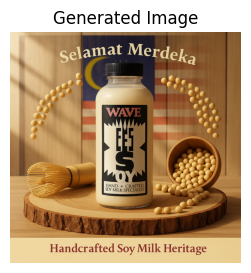

In [119]:
# image_path = r'D:\Self-Project\LLM\agent_ads\image_outputs\image-edit-tc027-1.png'

image = cv2.imread(ref_replace_filename)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_h, img_w = image.shape[:2]
print(f"Original Image Shape = {image.shape}")

plt.figure(figsize=(5, 3))
plt.imshow(image_rgb)
plt.title("Generated Image")
plt.axis('off')
plt.show()

In [120]:
image_bytes = open(ref_replace_filename, "rb").read()

result = await analysis_agent.run(
    [
        analysis_prompt,
        BinaryContent(data=image_bytes, media_type='image/jpg'),
    ]
)

print(result.data)

main_text='Selamat Merdeka' secondary_texts=['Handcrafted Soy Milk Heritage'] logo_present=True object_description='HAND. CRAFTED SOY MILK SPECIALIST' brand_name='WAVE EES SOY' corrections={'object_description': 'HANDCRAFTED SOY MILK SPECIALIST'}


In [121]:
# Road block : Brand Name Might be Wrong Here !!!
analysis_result_json = result.data.__dict__
analysis_result_json

{'main_text': 'Selamat Merdeka',
 'secondary_texts': ['Handcrafted Soy Milk Heritage'],
 'logo_present': True,
 'object_description': 'HAND. CRAFTED SOY MILK SPECIALIST',
 'brand_name': 'WAVE EES SOY',
 'corrections': {'object_description': 'HANDCRAFTED SOY MILK SPECIALIST'}}

In [122]:
def render_text_prompt(image_ctx_json):
    prompt_render = f"""
    You are editing an image to render promotional text onto it based on the following precise visual specification.

    **Contextual References**:
    - Main Object : {main_obj}
    - Text Styling Details: {image_ctx_json['visual_concept']['promotional_text_visuals']}
    
    **Instructions**:
    1. Carefully study the Text Styling Details to guide the appearance and placement of the promotional text.
    - These details serve as **style inspiration**, not fixed spatial rules.
    - You may adapt **positioning or layout** of the text to suit the image without compromising legibility or aesthetics.

    2. **Do not alter, shrink, resize, reposition, or visually obstruct** the main object (“{main_obj}”) in any way.
    - The object must remain visually dominant and unchanged in size, scale, and placement.
    - Preserve all existing content and composition in the image.

    3. **Flexibly adjust** the position of the promotional text to maintain:
    - Visual harmony with the scene
    - Clear readability without disrupting important visual elements
    - Balance in the overall composition (e.g., avoid crowding or overlapping)

    4. Do not generate or introduce any additional visual elements, effects, or annotations beyond what is required to render the described text.

    5. The final result should be clean, cohesive, and professionally styled — as if the text was originally designed into the image.

    6. Return only the final edited image with the rendered promotional text. Do not include design overlays, reference images, or explanatory labels.
    """
    # print(prompt_render)
    return prompt_render

In [ ]:
from sentence_transformers import SentenceTransformer, util

detected_img_txt = analysis_result_json.get('main_text', '')
print(f"Task Desc = {task_description}")
print(f"Detected Main Text = {detected_img_txt}")

# TODO: Pre processing before passing to embedding model
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
emb1 = model.encode(task_description, convert_to_tensor=True)
emb2 = model.encode(detected_img_txt, convert_to_tensor=True)

cosine_sim = util.pytorch_cos_sim(emb1, emb2).item()
print(f"Cosine Similarity = {cosine_sim}")


Task Desc = Merdeka Day Celebration
Detected Main Text = Selamat Merdeka
Cosine Similarity = 0.7896615862846375


In [131]:
rephrase_prompt=f"""You are given a phrase that may contain variations or misspellings of a target keyword. Your task is to replace any phrase or word that resembles the keyword with the exact canonical keyword.

Keyword: {braning_elements}

Phrase: {detected_brand}

Return the corrected phrase.
"""

In [ ]:

def create_text_enhancement_prompt(enhanced_type, detected_txt, expected_txt):
    if enhanced_type == 'brand_name':
        main_object = 'brand name'
        pass
    elif enhanced_type == 'task_desc':
        main_object = 'description'
        pass
    
    prompt = f"""
    You are editing an image that might contains visible branding and text description. 

    Instructions:
    1. Replace every instance of “{detected_txt}” with “{expected_txt}”,  preserving the original casing style — if the existing text is in all uppercase, the replacement must also appear in all uppercase.

    2. Maintain the original font style, size, color, positioning, and alignment exactly as seen in the source image. The updated text must seamlessly match the formatting and spatial layout of the original.

    3. Ensure the new text blends naturally with the surrounding design — matching textures, shadows, lighting, and perspective.

    4. Do not alter any other elements of the image or introduce additional text.

    5. Return only the edited image with the updated {main_object}.
    """
    # print(prompt)
    return prompt



# Comparison of extracted output with expected input
# Extract Branding and Text from User Input
print(f"="*30)
print(f"Render Text : {render_text}")
print(f"Task Describtion : {task_description}\n")
print(f"Apply Branding : {apply_branding}")
print(f"Branding Elements : {braning_elements}\n")
print(f"="*30)

# Check if brand name is alligned
# **ASSUMPTION: Branding Elements = Brand Name
prompt_replace_brand = ''
prompt_replace_text = ''
prompt_fixed_spelling = ''
if apply_branding:
    enhanced_type = 'brand_name'
    detected_brand = analysis_result_json.get('brand_name', '')
    detected_desc = analysis_result_json.get('object_description', '')
    corrections = analysis_result_json.get('corrections', '')
    corrected_desc = corrections.get('object_description', '')
    print(corrected_desc)
    if detected_brand == '':
        print(f"!!! Render Branding FAILED - Empty Brand Name Detected from Image.")
        
        prompt_replace_brand = f"Add the brand name '{braning_elements}' clearly to the main object ('{main_obj}') in a professional and visually integrated manner." 

    if braning_elements.lower() not in detected_brand.lower():
        print(f"!!! Brand Name - ({braning_elements}) not found in generated image. ")   
        
        response = await rephrase_agent.run(rephrase_prompt)
        rephrase_brand = response.data    
        print(rephrase_brand)
        
        prompt_replace_brand = f"""Replace the current brand name '{detected_brand}' on the main object ('{main_obj}') with '{rephrase_brand}', preserving the original placement, style, and formatting.
        """
        # prompt_fixed_spelling = f"""Fix any misspelled English words in the visible description text on the main object ('{detected_desc}'), ensure the corrected text retains the original meaning and fits the branding tone and visual styling.
        # """
        if corrected_desc: 
            prompt_fixed_spelling = f"""Replace the current object description '{detected_desc}' on the main object  ('{main_obj}') with '{corrected_desc}', preserve the orignal placement, style, and formatting.
            """

# Check if render text is alligned
# **ASSUMPTION: Task description = Text to be rendered
if render_text:
    enhanced_type = 'task_desc'
    detected_img_txt = analysis_result_json.get('main_text', '')
    detected_img_txt = str(detected_img_txt).replace('\\n', ', ').replace('\n', ', ')
    # 3. No text generated in image although provided by user
    if not detected_img_txt:
        print("!!! Render Text FAILED - Empty Text Detected from Image")
        prompt_replace_text = render_text_prompt(image_ctx_json)
        
    
    # 4. Generated text does not match the user input
    elif task_description and task_description.lower() not in str(detected_img_txt).lower() and cosine_sim < 0.6:
        print(f"!!! Task description text ('{task_description}') not found in generated image. \n")
        prompt_replace_text = create_text_enhancement_prompt(
            enhanced_type, 
            detected_txt=detected_img_txt, 
            expected_txt=task_description
        )
        
# Merge both prompts on wrong brand name and text description.
# TODO: Restructure on empty Replace Text
if prompt_replace_text:
    if prompt_replace_brand and prompt_fixed_spelling:
        prompt_replace_text += f"\n    6. {prompt_replace_brand}"
        prompt_replace_text += f"\n    7. {prompt_fixed_spelling}"
    elif prompt_replace_brand: 
        prompt_replace_text += f"\n    6. {prompt_replace_brand}"
else: 
    if prompt_replace_brand and prompt_fixed_spelling:
        prompt_replace_text += f"\n    1. {prompt_replace_brand}"
        prompt_replace_text += f"\n    2. {prompt_fixed_spelling}"
    elif prompt_replace_brand: 
        prompt_replace_text += f"\n    1. {prompt_replace_brand}"
    

print(f"Final Prompt : {prompt_replace_text}")

Render Text : True
Task Describtion : Merdeka Day Celebration

Apply Branding : True
Branding Elements : EESOY

HANDCRAFTED SOY MILK SPECIALIST
!!! Brand Name - (EESOY) not found in generated image. 
WAVE EESOY
Final Prompt : 
    6. Replace the current brand name 'WAVE EES SOY' on the main object ('Bottle of handcrafted soy milk') with 'WAVE EESOY', preserving the original placement, style, and formatting.
        
    7. Replace the current object description 'HAND. CRAFTED SOY MILK SPECIALIST' on the main object  ('Bottle of handcrafted soy milk') with 'HANDCRAFTED SOY MILK SPECIALIST', preserve the orignal placement, style, and formatting.
            


In [ ]:
image_client = OpenAI(api_key'')

if prompt_replace_text: 
    result = image_client.images.edit(
        model="gpt-image-1",
        image=[
            open(ref_replace_filename, "rb"),
        ],
        prompt=prompt_replace_text,
        quality='high',
        size='1024x1024'
    )

    image_base64 = result.data[0].b64_json
    image_bytes = base64.b64decode(image_base64)

    # Save the image to a file
    filename = f"{base_path_downstream}/{folder}/image-text-replace-{idx}-0.png"
    if os.path.exists(filename):
        raise ValueError("Image Path already Exists !")

    with open(filename, "wb") as f:
        f.write(image_bytes)
else: 
    # Rename Image 
    print(f"No Text Replacement Required.")
    pass

#### Custom Command to Replace Parts of Image

In [ ]:
# TODO: Replace incorrect text from image
prompt= f"""

"""